In [ ]:
# Barest Soil 

### Fei Zhang @Geoscience Australia

August 2016

## Introduction

Find the barest soil Earth observations from time series analysis. The result data  will be used as input for the mineral resources uncover project:  machine-learning application.

Here are the centre point locations for 3 study aread with different vegetation/bareness relationships;

1. Edge of fire scar (NT) 19:36:10.24S//132:34:55.72E

2. Farming land (crops (green and fallow paddocks - Western NSW)30:5:45.33S/148:11:29.75E

3. Woodland (remain greenish most of the time - the understory should change in response to seasonal drying out)22:52:35.4S/147:24:11.25E

extract a 5X5 km or 10X10km tile for each area. Then select only tiles with < 10% poor quality pixels (e.g. noise , cloud etc.). From that subset we run NDVI and then run a median kernel (3*3 ?) to smooth out noisy pixels. The kernel needs to accommodate crappy pixels as no data values. After that we calculate the average NDVI response for whole the tile. We should try a keep the tiles in chronological order because when we process all the tiles through time series and plot up the average NDVI value for each tile we will want to see trends of drying out (increased bareness) due to seasonal effects or recovery from fire scars. I suggest we look at the image tiles along each step of the work flow. There are lots of parameters (size of tile, size and shape of the kernel etc) we can change  - but as a first step this might be a good start. 

Fei we might want to have further discussions when you have selected a sub-group of tiles with good pixel quality. I suppose this first step assumes that we have a very good pixel quality mask or flag?
We have significant temporal depth - so if in doubt exclude problematic tiles.





## Interactive Computing

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math
import pandas

import sys
sys.path.insert(0, '/g/data/u46/fxz547/Githubz/agdc-v2')#'/home/547/fxz547/myGithub/agdc-v2')  #prepend a path

In [2]:
# import AGDC Python API modules

import datacube
from datacube.storage import masking

# Create an API data access object
dc = datacube.Datacube(app='BarestSoil')

dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://fxz547@130.56.244.227:6432/datacube)>>>

We can access the Postgres Database (metadata index) and its associated imagery data.

## Retrieving data


In [3]:
#To see the function signature?
#dc.load?

# Where?
# xp=(149.00, 149.20); yp=(-35.25, -35.35)  # Lake Burley Griffin x=(149.07, 149.17), y=(-35.25, -35.35), 
# xp=( 149.160,  149.170); yp=(-35.34 , -35.35 )  #a small area cover GA water pond

# Edge of fire scar (NT) 19:36:10.24S//132:34:55.72E
#xp=(132.50, 132.60); yp=(-19.7, -19.5)  # 0.1degree =~ 10km 
# xp=(132.50, 132.60); yp=(-19.65, -19.55)

#Farming land (crops (green and fallow paddocks - Western NSW)30:5:45.33S/148:11:29.75E
xp=(148.14, 148.24); yp=(-30.15, -30.05)  # North of Dubbo, inside NSW border

#Woodland (greenish most of the time. the understory should change in response to seasonal drying out)22:52:35.4S/147:24:11.25E
xp=(147.35, 147.45); yp=(-22.92, -22.82)  # west of Rockhampton
                
# When? a time range
tp=('1980-01', '2016-12-31')

prod_type='ls5_nbar_albers'

##  Applications based on AGDC

### Derive information products 
### Must identify and remove invalid observations: cloud, shadow, satuared pixels

### Band maths: combine the bands to derive new variables (artificial bands)

-  Normalized Difference Vegetation Index, NDVI
-  Normalized Difference Water Index,  NDWI
-  These index can help to clearly identify certain land cover features: Vegetation, water bodies

In [4]:
prod_type
pq_prod_type = prod_type.replace('nbar','pq')

In [5]:
def get_ndvi_mean(prod_type, xp, yp, tp):
    blist= ['red', 'nir'] #, 'green', 'swir1']
    bands = dc.load(product=prod_type, x=xp, y=yp, time=tp, measurements= blist, group_by='solar_day')
    red = bands.red.where(bands.red != bands.red.attrs['nodata'])
    nir = bands.nir.where(bands.nir != bands.nir.attrs['nodata'])

    # green = bands.green.where(bands.green != bands.green.attrs['nodata'])
    # swir1 = bands.swir1.where(bands.swir1 != bands.swir1.attrs['nodata'])

    # Retrieve the associated Pixel Quality datasets ls8_pq_albers
    pq_prod_type = prod_type.replace('nbar','pq')
    pq = dc.load(product=pq_prod_type, x=xp, y=yp,  time=tp, group_by='solar_day')

    print (len(bands.time), len(pq.time))

    cloud_free = masking.make_mask(pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', contiguous=True).pixelquality

    # Normalized Differenc Vegetation Index: Red and near Infrared bands

    ndvi = ((nir - red) / (nir + red)).where(cloud_free)

    # Normalized Differenc Water Index: Green and Shortwave Infrared Bands

    #ndwi = ((swir1- green)/(green + swir1)).where(cloud_free)

    #ndwi = ((green- swir1)/(green + swir1)).where(cloud_free)

    print(ndvi.shape)

    # xarray.Dataset.sum to reduce the datasets by selecting the time slices with high percentage cloud-free pixels
    #  Weed out the low quality images
    cloudfreeRatio = 0.9  # threshold of cloud pixel 80%

    mostly_cloud_free = cloud_free.sum(dim=('x','y')) > (cloudfreeRatio * cloud_free.size / cloud_free.time.size)

    #print(mostly_cloud_free)
    
    print("How many cloudless images selected?", mostly_cloud_free.sum().values)
    
    # Apply the time-dim mask to the 3D-array (time, x, y)
    mostly_good_ndvi = ndvi.where(mostly_cloud_free).dropna('time', how='all')
    # mostly_good_ndvi.plot(col='time', col_wrap=5)
    
    #xarray:  mostly_good_ndvi

    ndvi_mean=mostly_good_ndvi.mean(dim=['x','y'])
    
    pdser=ndvi_mean.to_pandas()  # pd.Series
    
    
    df= pdser.to_frame(name='NDVI') # convert to dataframe
    
    df['PROD_TYPE']= prod_type  # add a new column
    
    return df


In [6]:
# Edge of fire scar (NT) 19:36:10.24S//132:34:55.72E
# 0.1degree =~ 10km 
AOI_NAME='FireScarNT'; xp=(132.50, 132.60); yp=(-19.65, -19.55)

#Farming land (crops (green and fallow paddocks - Western NSW)30:5:45.33S/148:11:29.75E
#AOI_NAME='Farmland'; xp=(148.14, 148.24); yp=(-30.15, -30.05)

#Woodland (greenish most of the time. the understory should change in response to seasonal drying out)22:52:35.4S/147:24:11.25E
#AOI_NAME='Woodland'; xp=(147.35, 147.45); yp=(-22.92, -22.82) 
                
# When? a time range
tp=('1980-01', '2016-12-31')

prod_type='ls8_nbar_albers'

df_ndvi_ls8=get_ndvi_mean('ls8_nbar_albers', xp,yp,tp)



(93, 78)
(78, 447, 421)
('How many cloudless images selected?', array(46))


In [7]:
df_ndvi_ls8.head()

,NDVI,PROD_TYPE
time,,
2013-03-20,0.260915,ls8_nbar_albers
2013-04-21,0.238060,ls8_nbar_albers
2013-06-24,0.222370,ls8_nbar_albers
2013-07-10,0.210408,ls8_nbar_albers
2013-07-26,0.208461,ls8_nbar_albers


In [8]:
prod_type='ls7_nbar_albers'

df_ndvi_ls7=get_ndvi_mean(prod_type, xp,yp,tp)

(296, 252)
(252, 447, 421)
('How many cloudless images selected?', array(35))


In [9]:
# ls5
prod_type='ls5_nbar_albers'
df_ndvi_ls5=get_ndvi_mean(prod_type, xp,yp,tp)


(594, 503)
(503, 447, 421)
('How many cloudless images selected?', array(284))


In [10]:
ndvi578=pandas.concat([df_ndvi_ls5, df_ndvi_ls7, df_ndvi_ls8])

In [11]:
ndvi578.shape

(365, 2)

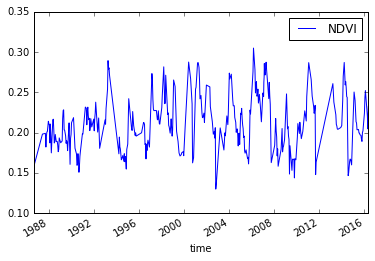

In [12]:
plt.figure( figsize=(20,10) )
ndvi578.plot()

In [13]:
#ndvi_mean

In [14]:
outcsvfile='meanNDVI578_%s.csv'% (AOI_NAME)

ndvi578.to_csv(outcsvfile)  #('/tmp/meanNDVI578_FireScarNT.csv')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7e88dd0650>]], dtype=object)

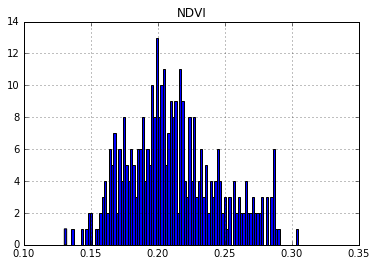

In [15]:
ndvi578.hist(bins=100)

In [16]:
p10= ndvi578.quantile(0.1)
p90= ndvi578.quantile(0.9)

bot_tenperc=ndvi578[(ndvi578['NDVI'] <= p10[0])].dropna()
top_tenperc=ndvi578[(ndvi578['NDVI'] >= p90[0])].dropna()

In [17]:
outcsvfile2='meanNDVI578_%s_bot10pc.csv'% (AOI_NAME)
bot_tenperc.to_csv(outcsvfile2)

outcsvfile3='meanNDVI578_%s_top10pc.csv'% (AOI_NAME)
top_tenperc.to_csv(outcsvfile3)

In [18]:
top_tenperc

,NDVI,PROD_TYPE
time,,
1993-03-29,0.289418,ls5_nbar_albers
1993-04-14,0.278615,ls5_nbar_albers
1993-04-30,0.280542,ls5_nbar_albers
1993-05-16,0.271592,ls5_nbar_albers
1997-02-20,0.273365,ls5_nbar_albers
1997-03-08,0.265467,ls5_nbar_albers
1998-03-11,0.281733,ls5_nbar_albers
1998-05-14,0.271358,ls5_nbar_albers
1999-01-25,0.265423,ls5_nbar_albers


In [19]:
p10

NDVI    0.167907
dtype: float64

In [20]:
bot_tenperc

,NDVI,PROD_TYPE
time,,
1986-08-17,0.157014,ls5_nbar_albers
1989-11-13,0.160806,ls5_nbar_albers
1990-06-25,0.159617,ls5_nbar_albers
1990-07-11,0.160343,ls5_nbar_albers
1990-08-12,0.164528,ls5_nbar_albers
1990-08-28,0.151027,ls5_nbar_albers
1990-09-13,0.158584,ls5_nbar_albers
1994-06-04,0.166472,ls5_nbar_albers
1994-06-20,0.167872,ls5_nbar_albers


In [21]:
stop here

#http://scikit-image.org/docs/stable/api/skimage.filters.html?highlight=local%20median%20filter
>>> from skimage import data
>>> from skimage.morphology import disk
>>> from skimage.filters.rank import median
>>> img = data.camera()
>>> med = median(img, disk(5))

SyntaxError: invalid syntax (<ipython-input-21-d67ea3c8f5f4>, line 1)

## Normalised Difference Water Index

In [ ]:
# images after removed invalid pixels. 
#ndwi.plot(col='time', col_wrap=6)


### Weed out the low quality images.

In [ ]:
# apply the cloud_threshold mask, which will select a subset images with good pixels. 

mostly_good_ndwi = ndwi.where(mostly_cloud_free).dropna('time', how='all')

mostly_good_ndwi.plot(col='time', col_wrap=5)

## Statistics Median and Mean Images

### Normalised Vegetation Index vs Water Index

In [ ]:
plt.figure( figsize=(16,12) )
    
plt.subplot( 2,2,1 )
mostly_good_ndvi.median(dim='time').plot()
plt.title("Median Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,2 )
mostly_good_ndvi.mean(dim='time').plot()
# ndvi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Vegetation Index - NDVI"); plt.xlabel('easting'); plt.ylabel('northing')

#------------------------------
plt.subplot( 2,2,3 )
mostly_good_ndwi.median(dim='time').plot()
plt.title("Median Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')


plt.subplot( 2,2,4 )
mostly_good_ndwi.mean(dim='time').plot()
# ndwi.mean(dim='time').plot()
plt.title("Mean Normalised Difference Water Index - NDWI"); plt.xlabel('easting'); plt.ylabel('northing')

# Water Observation from Space

http://eos-test.ga.gov.au/geoserver/www/remote_scripts/WOfS_v1.6.htm
